# CKKS Parameter Sensitivity ablation study

Analysis of polynomial modulus, scale, dimensionality, and implicit noise budget behavior using the 32/88/93/181 dimensional datasets. Uses full test sets (400 samples) for robust metrics.

In [1]:
# Imports and configuration
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import tenseal as ts
from sklearn.metrics import roc_auc_score, brier_score_loss

DATA_DIR = Path('data/synthetic')
BASELINE_DIR = Path('artifacts/plaintext_baseline')
ARTIFACT_DIR = Path('artifacts/parameter_sensitivity')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
DIMENSIONS = [
    {'name': '32-dim', 'folder': '32dim'},
    {'name': '88-dim', 'folder': '88dim'},
    {'name': '93-dim', 'folder': '93dim'},
    {'name': '181-dim', 'folder': '181dim'}
]

## Helper Functions

In [2]:
def ensure_finite(label, array):
    if not np.all(np.isfinite(array)):
        raise ValueError(f"{label} contains non-finite values")
    return array


def resolve_baseline(folder_name):
    candidate = BASELINE_DIR / folder_name
    if candidate.exists():
        coef = ensure_finite('coefficients', np.load(candidate / 'coefficients.npy'))
        with open(candidate / 'intercept.txt', 'r') as f:
            intercept = float(f.read().strip())
            return coef, intercept
    raise FileNotFoundError(f'Baseline not found for {folder_name}')


def load_data(folder_name, max_samples=None):
    folder = DATA_DIR / folder_name
    X_test = ensure_finite('X_test', np.load(folder / 'X_test.npy'))
    y_test = ensure_finite('y_test', np.load(folder / 'y_test.npy'))
    if max_samples is not None:
        X_test = X_test[:max_samples]
        y_test = y_test[:max_samples]
    return X_test, y_test


def create_context(poly_modulus_degree, coeff_mod_bit_sizes, scale_bits):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=poly_modulus_degree,
        coeff_mod_bit_sizes=coeff_mod_bit_sizes
    )
    context.global_scale = 2 ** scale_bits
    context.generate_galois_keys()
    return context


def encrypted_dot_products(X, coef, intercept, context):
    coef_enc = ts.ckks_vector(context, coef.tolist())
    logits = []
    latencies = []
    for sample in X:
        t0 = time.perf_counter()
        x_enc = ts.ckks_vector(context, sample.tolist())
        logit_enc = x_enc.dot(coef_enc) + intercept
        logits.append(logit_enc.decrypt()[0])
        latencies.append((time.perf_counter() - t0) * 1000)
    return ensure_finite('encrypted logits', np.array(logits)), ensure_finite('latencies', np.array(latencies))

## Ablation Configuration

We test three polynomial modulus degrees (8192, 16384, 32768) and five scale values (20–60 bits) to observe the full precision-stability trade-off curve.

In [3]:
POLY_MODULUS_GRID = [
    {'poly_modulus_degree': 8192, 'coeff_mod_bit_sizes': [60, 40, 40, 60], 'scale_bits': 40},
    {'poly_modulus_degree': 16384, 'coeff_mod_bit_sizes': [60, 40, 40, 40, 60], 'scale_bits': 40},
    {'poly_modulus_degree': 32768, 'coeff_mod_bit_sizes': [60, 40, 40, 40, 40, 60], 'scale_bits': 40}
]
SCALE_GRID = [20, 30, 40, 50, 60]
DIM_GRID = DIMENSIONS

ERRSTATE_KWARGS = dict(divide='ignore', invalid='ignore', over='ignore')

In [4]:
records = []
for dim in DIM_GRID:
    X_test, y_test = load_data(dim['folder'], max_samples=None)
    coef, intercept = resolve_baseline(dim['folder'])
    
    with np.errstate(**ERRSTATE_KWARGS):
        logits_plain = X_test @ coef + intercept
        probs_plain = 1 / (1 + np.exp(-logits_plain))
    ensure_finite('plaintext logits', logits_plain)
    ensure_finite('plaintext probs', probs_plain)
    
    auc_plain = roc_auc_score(y_test, probs_plain)
    brier_plain = brier_score_loss(y_test, probs_plain)

    for cfg in POLY_MODULUS_GRID:
        for scale_bits in SCALE_GRID:
            print(f"  {dim['name']}: poly={cfg['poly_modulus_degree']}, scale={scale_bits}")
            try:
                context = create_context(
                    cfg['poly_modulus_degree'],
                    cfg['coeff_mod_bit_sizes'],
                    scale_bits
                )
                logits_enc, latencies = encrypted_dot_products(X_test, coef, intercept, context)
                
                with np.errstate(**ERRSTATE_KWARGS):
                    probs_enc = 1 / (1 + np.exp(-logits_enc))
                ensure_finite('encrypted probs', probs_enc)

                record = {
                    'Dataset': dim['name'],
                    'Dimensionality': X_test.shape[1],
                    'poly_modulus_degree': cfg['poly_modulus_degree'],
                    'scale_bits': scale_bits,
                    'coeff_mod_bit_sizes': str(cfg['coeff_mod_bit_sizes']),
                    'auc_plain': auc_plain,
                    'auc_encrypted': roc_auc_score(y_test, probs_enc),
                    'brier_plain': brier_plain,
                    'brier_encrypted': brier_score_loss(y_test, probs_enc),
                    'auc_delta': abs(roc_auc_score(y_test, probs_enc) - auc_plain),
                    'logit_mae': float(np.mean(np.abs(logits_enc - logits_plain))),
                    'latency_median_ms': float(np.median(latencies)),
                    'latency_p95_ms': float(np.percentile(latencies, 95)),
                    'status': 'success'
                }
            except (RuntimeError, ValueError) as e:
                print(f"    FAILED: {e}")
                record = {
                    'Dataset': dim['name'],
                    'Dimensionality': X_test.shape[1],
                    'poly_modulus_degree': cfg['poly_modulus_degree'],
                    'scale_bits': scale_bits,
                    'coeff_mod_bit_sizes': str(cfg['coeff_mod_bit_sizes']),
                    'auc_plain': auc_plain,
                    'auc_encrypted': np.nan,
                    'brier_plain': brier_plain,
                    'brier_encrypted': np.nan,
                    'auc_delta': np.nan,
                    'logit_mae': np.nan,
                    'latency_median_ms': np.nan,
                    'latency_p95_ms': np.nan,
                    'status': f'failed: {str(e)[:50]}'
                }
            records.append(record)

results_df = pd.DataFrame(records)
display(results_df.head(20))
results_path = ARTIFACT_DIR / 'parameter_sensitivity_results.csv'
results_df.to_csv(results_path, index=False)
print('Saved results to', results_path)

  32-dim: poly=8192, scale=20
  32-dim: poly=8192, scale=30
  32-dim: poly=8192, scale=30
  32-dim: poly=8192, scale=40
  32-dim: poly=8192, scale=40
  32-dim: poly=8192, scale=50
  32-dim: poly=8192, scale=50
  32-dim: poly=8192, scale=60
  32-dim: poly=8192, scale=60
  32-dim: poly=16384, scale=20
  32-dim: poly=16384, scale=20
  32-dim: poly=16384, scale=30
  32-dim: poly=16384, scale=30
  32-dim: poly=16384, scale=40
  32-dim: poly=16384, scale=40
  32-dim: poly=16384, scale=50
  32-dim: poly=16384, scale=50
  32-dim: poly=16384, scale=60
  32-dim: poly=16384, scale=60
  32-dim: poly=32768, scale=20
  32-dim: poly=32768, scale=20
  32-dim: poly=32768, scale=30
  32-dim: poly=32768, scale=30
  32-dim: poly=32768, scale=40
  32-dim: poly=32768, scale=40
  32-dim: poly=32768, scale=50
  32-dim: poly=32768, scale=50
  32-dim: poly=32768, scale=60
  32-dim: poly=32768, scale=60
  88-dim: poly=8192, scale=20
  88-dim: poly=8192, scale=20
  88-dim: poly=8192, scale=30
  88-dim: poly=8192,

,Dataset,Dimensionality,poly_modulus_degree,scale_bits,coeff_mod_bit_sizes,auc_plain,auc_encrypted,brier_plain,brier_encrypted,auc_delta,logit_mae,latency_median_ms,latency_p95_ms,status
0,32-dim,32,8192,20,"[60, 40, 40, 60]",0.902525,0.456900,0.127099,0.348908,0.445625,2.202476e+00,6.080063,6.255165,success
1,32-dim,32,8192,30,"[60, 40, 40, 60]",0.902525,0.902050,0.127099,0.249612,0.000475,1.921718e+00,6.109959,6.323600,success
2,32-dim,32,8192,40,"[60, 40, 40, 60]",0.902525,0.902525,0.127099,0.127099,0.000000,1.610581e-06,6.128041,6.365911,success
3,32-dim,32,8192,50,"[60, 40, 40, 60]",0.902525,0.849425,0.127099,0.186924,0.053100,1.967926e+03,6.119708,6.313236,success
4,32-dim,32,8192,60,"[60, 40, 40, 60]",0.902525,0.812500,0.127099,0.187500,0.090025,2.017124e+06,6.128062,6.312726,success
5,32-dim,32,16384,20,"[60, 40, 40, 40, 60]",0.902525,0.482900,0.127099,0.345012,0.419625,2.185915e+00,19.257521,19.715566,success
6,32-dim,32,16384,30,"[60, 40, 40, 40, 60]",0.902525,0.903025,0.127099,0.249610,0.000500,1.921723e+00,19.262271,19.667624,success
7,32-dim,32,16384,40,"[60, 40, 40, 40, 60]",0.902525,0.902525,0.127099,0.127099,0.000000,4.691293e-06,19.305500,19.717973,success
8,32-dim,32,16384,50,"[60, 40, 40, 40, 60]",0.902525,0.849425,0.127099,0.186924,0.053100,1.967928e+03,19.310396,19.644885,success
9,32-dim,32,16384,60,"[60, 40, 40, 40, 60]",0.902525,0.812500,0.127099,0.187500,0.090025,2.017126e+06,19.315562,19.680581,success


Saved results to artifacts/parameter_sensitivity/parameter_sensitivity_results.csv


## Visualizations

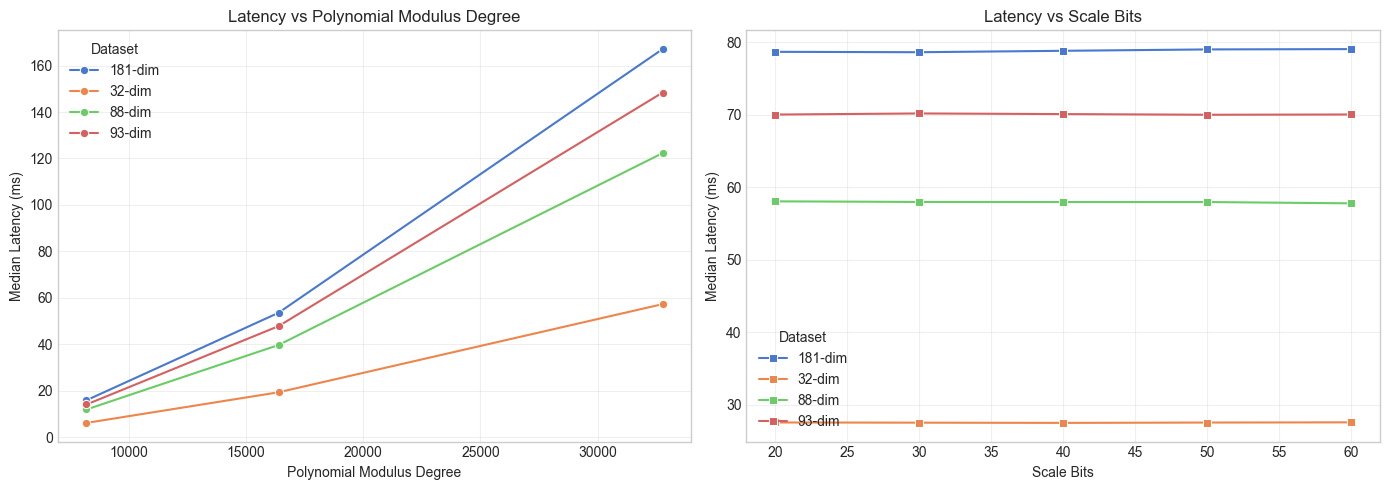

Saved latency sensitivity plot to artifacts/parameter_sensitivity/latency_sensitivity.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')

# Latency vs Polynomial Modulus Degree
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Median latency by poly_modulus_degree and dimensionality
latency_by_deg = results_df.groupby(['Dataset', 'poly_modulus_degree'])['latency_median_ms'].mean().reset_index()
sns.lineplot(data=latency_by_deg, x='poly_modulus_degree', y='latency_median_ms', hue='Dataset', marker='o', ax=axes[0])
axes[0].set_xlabel('Polynomial Modulus Degree')
axes[0].set_ylabel('Median Latency (ms)')
axes[0].set_title('Latency vs Polynomial Modulus Degree')
axes[0].legend(title='Dataset')
axes[0].grid(True, alpha=0.3)

# Right panel: Latency by scale_bits and dimensionality
latency_by_scale = results_df.groupby(['Dataset', 'scale_bits'])['latency_median_ms'].mean().reset_index()
sns.lineplot(data=latency_by_scale, x='scale_bits', y='latency_median_ms', hue='Dataset', marker='s', ax=axes[1])
axes[1].set_xlabel('Scale Bits')
axes[1].set_ylabel('Median Latency (ms)')
axes[1].set_title('Latency vs Scale Bits')
axes[1].legend(title='Dataset')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
latency_path = ARTIFACT_DIR / 'latency_sensitivity.png'
plt.savefig(latency_path, dpi=150)
plt.show()
print('Saved latency sensitivity plot to', latency_path)

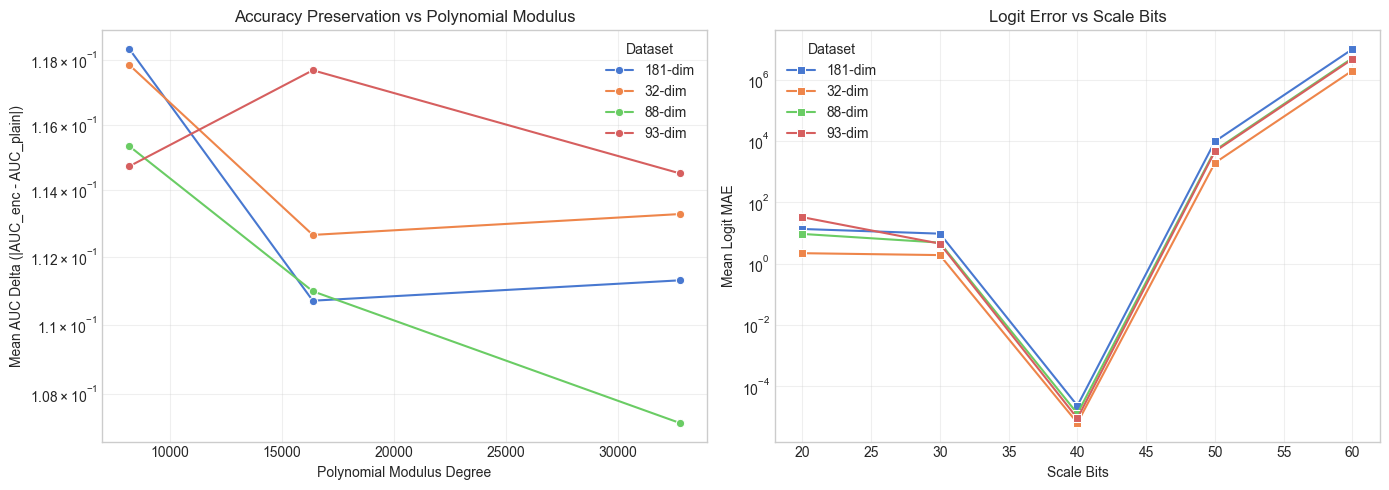

Saved accuracy sensitivity plot to artifacts/parameter_sensitivity/accuracy_sensitivity.png


In [6]:
# 2. Accuracy Preservation: AUC Delta and Logit MAE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: AUC delta by poly_modulus_degree
auc_by_deg = results_df.groupby(['Dataset', 'poly_modulus_degree'])['auc_delta'].mean().reset_index()
sns.lineplot(data=auc_by_deg, x='poly_modulus_degree', y='auc_delta', hue='Dataset', marker='o', ax=axes[0])
axes[0].set_xlabel('Polynomial Modulus Degree')
axes[0].set_ylabel('Mean AUC Delta (|AUC_enc - AUC_plain|)')
axes[0].set_title('Accuracy Preservation vs Polynomial Modulus')
axes[0].set_yscale('log')
axes[0].legend(title='Dataset')
axes[0].grid(True, alpha=0.3, which='both')

# Right panel: Logit MAE by scale_bits
logit_by_scale = results_df.groupby(['Dataset', 'scale_bits'])['logit_mae'].mean().reset_index()
sns.lineplot(data=logit_by_scale, x='scale_bits', y='logit_mae', hue='Dataset', marker='s', ax=axes[1])
axes[1].set_xlabel('Scale Bits')
axes[1].set_ylabel('Mean Logit MAE')
axes[1].set_title('Logit Error vs Scale Bits')
axes[1].set_yscale('log')
axes[1].legend(title='Dataset')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
accuracy_path = ARTIFACT_DIR / 'accuracy_sensitivity.png'
plt.savefig(accuracy_path, dpi=150)
plt.show()
print('Saved accuracy sensitivity plot to', accuracy_path)

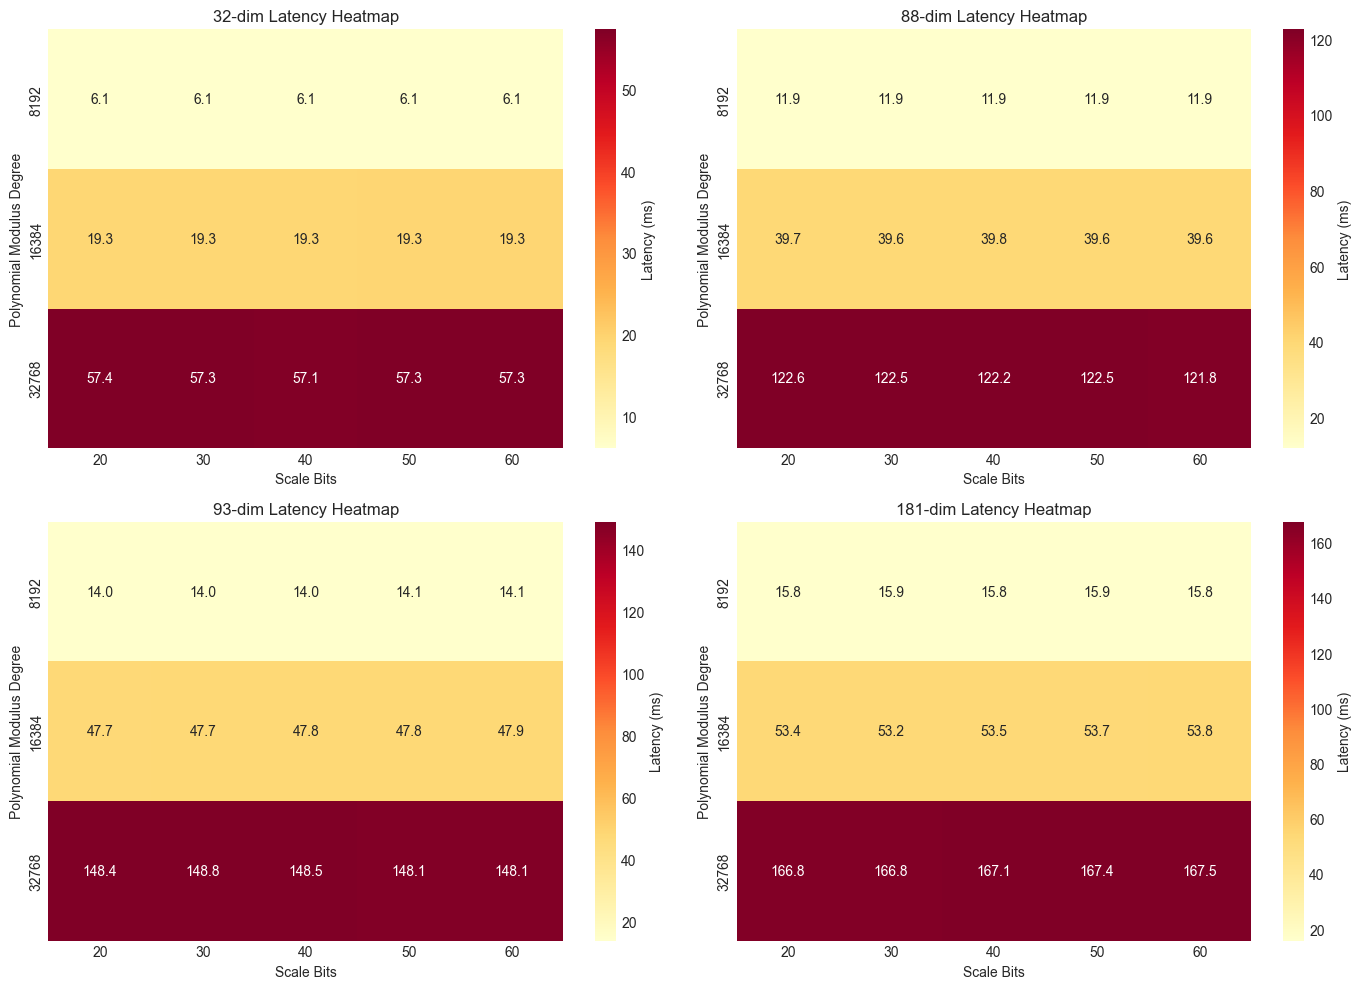

Saved latency heatmap to artifacts/parameter_sensitivity/latency_heatmap.png


In [7]:
# 3. Heatmap: Latency by Polynomial Modulus Degree and Scale Bits
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, dim in enumerate(DIMENSIONS):
    ax = axes[idx // 2, idx % 2]
    dim_data = results_df[results_df['Dataset'] == dim['name']]
    pivot = dim_data.pivot_table(
        index='poly_modulus_degree',
        columns='scale_bits',
        values='latency_median_ms',
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Latency (ms)'})
    ax.set_title(f'{dim["name"]} Latency Heatmap')
    ax.set_xlabel('Scale Bits')
    ax.set_ylabel('Polynomial Modulus Degree')

plt.tight_layout()
heatmap_path = ARTIFACT_DIR / 'latency_heatmap.png'
plt.savefig(heatmap_path, dpi=150)
plt.show()
print('Saved latency heatmap to', heatmap_path)

In [8]:
# 4. Summary Table: Best Configurations per Dimensionality
# Define 'best' as lowest latency while maintaining auc_delta < 0.01
acceptable = results_df[results_df['auc_delta'] < 0.01].copy()
if acceptable.empty:
    print('Warning: No configurations with auc_delta < 0.01. Relaxing to auc_delta < 0.05.')
    acceptable = results_df[results_df['auc_delta'] < 0.05].copy()

best_configs = acceptable.loc[acceptable.groupby('Dataset')['latency_median_ms'].idxmin()]
best_configs_display = best_configs[['Dataset', 'Dimensionality', 'poly_modulus_degree', 'scale_bits', 
                                      'auc_delta', 'logit_mae', 'latency_median_ms', 'latency_p95_ms']]
print('\nBest Configurations (lowest latency, auc_delta < threshold):')
display(best_configs_display)

best_path = ARTIFACT_DIR / 'best_configurations.csv'
best_configs_display.to_csv(best_path, index=False)
print('Saved best configurations to', best_path)


Best Configurations (lowest latency, auc_delta < threshold):


,Dataset,Dimensionality,poly_modulus_degree,scale_bits,auc_delta,logit_mae,latency_median_ms,latency_p95_ms
47,181-dim,181,8192,40,0.000000,0.000002,15.837646,16.161460
1,32-dim,32,8192,30,0.000475,1.921718,6.109959,6.323600
16,88-dim,88,8192,30,0.000200,4.917957,11.899146,12.252046
31,93-dim,93,8192,30,0.000025,4.548923,13.990813,14.359204


Saved best configurations to artifacts/parameter_sensitivity/best_configurations.csv


## Accuracy-Latency Trade-off

We visualize the complete CKKS parameter space with accuracy vs latency trade-offs.

## Accuracy-Latency Trade-off

Visualize the complete CKKS parameter space with accuracy vs latency trade-offs.

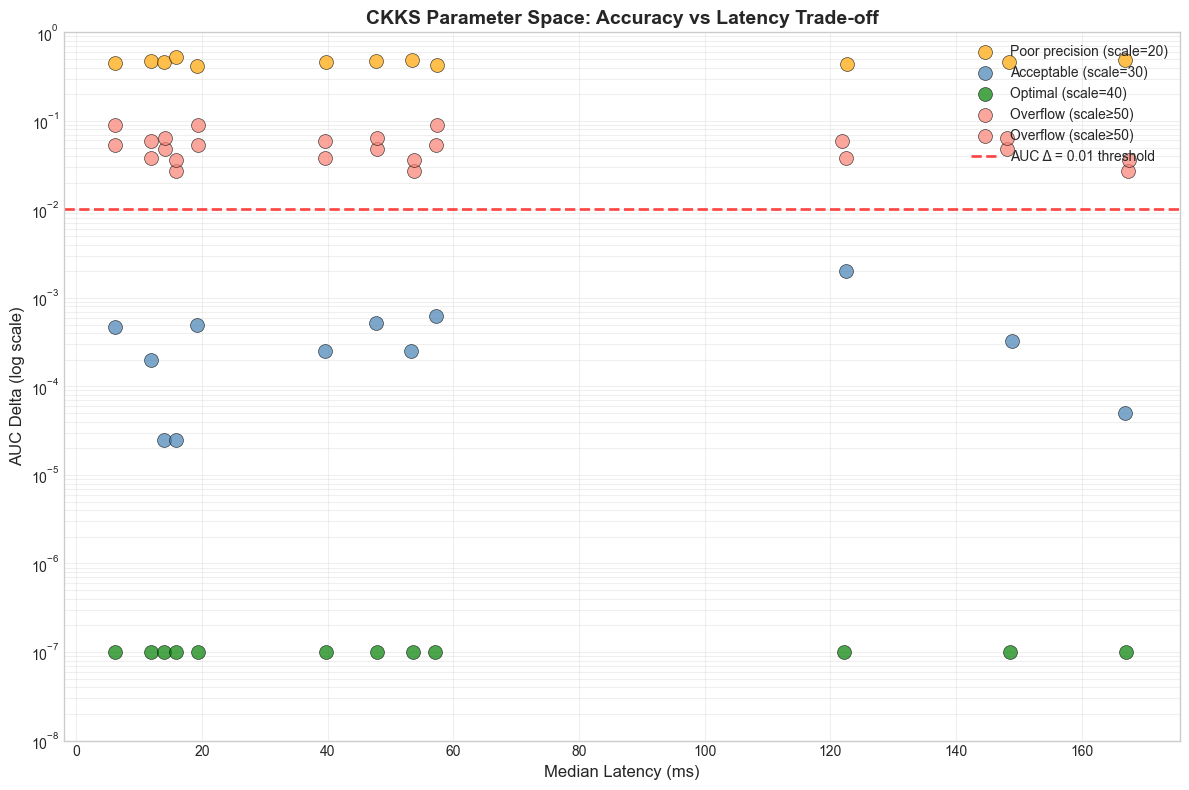

Saved Pareto frontier plot to artifacts/parameter_sensitivity/pareto_frontier.png


In [12]:
plot_df = results_df.copy()
plot_df['auc_delta_viz'] = plot_df['auc_delta'].clip(lower=1e-7)  # Floor at 10^-7 for log scale visibility

# Color by scale parameter
scale_colors = {
    20: 'orange',      # Poor precision
    30: 'steelblue',   # Acceptable
    40: 'green',       # Optimal
    50: 'salmon',      # Overflow
    60: 'salmon'       # Severe overflow
}

fig, ax = plt.subplots(figsize=(12, 8))

for scale in SCALE_GRID:
    data = plot_df[plot_df['scale_bits'] == scale]
    label = f'scale={scale}'
    if scale == 20:
        label = 'Poor precision (scale=20)'
    elif scale == 30:
        label = 'Acceptable (scale=30)'
    elif scale == 40:
        label = 'Optimal (scale=40)'
    elif scale >= 50:
        label = 'Overflow (scale≥50)'
    
    ax.scatter(data['latency_median_ms'], data['auc_delta_viz'], 
               c=scale_colors.get(scale, 'gray'), s=100, alpha=0.7, 
               label=label, edgecolors='black', linewidths=0.5)

# Add acceptability threshold
ax.axhline(y=0.01, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='AUC Δ = 0.01 threshold')

ax.set_xlabel('Median Latency (ms)', fontsize=12)
ax.set_ylabel('AUC Delta (log scale)', fontsize=12)
ax.set_title('CKKS Parameter Space: Accuracy vs Latency Trade-off', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.set_ylim(1e-8, 1)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
pareto_path = ARTIFACT_DIR / 'pareto_frontier.png'
plt.savefig(pareto_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved Pareto frontier plot to {pareto_path}')